In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['HF_HOME'] = 'hf_cache' # Don't want model files in our home directory due to disk quota
os.environ['OPENBLAS_NUM_THREADS'] = '1' # https://stackoverflow.com/questions/75619847/python-sklearn-openblas-error-for-kmeans

from utils import set_seed
import torch

set_seed(1234)

torch.cuda.is_available()

True

In [2]:
from transformers import LukeTokenizer
import const
from model import DocRedModel
import json
from utils import get_holdouts, remove_holdouts, read_docred, collate_fn
from train import train_official, train_contr_candidates, train_contr_cluster
from torch.utils.data import DataLoader

HOLDOUT_BATCH = 0
MODEL_NAME = const.LUKE_BASE

CAND_TMP = 0.01
CAND_SUP_WT = 0.5
CAND_EMBED_SIZE = 768
CAND_NORMALIZE = True

TRAIN_BATCH_SIZE = 4 # Should we reduce contrastive batch size to 3? This is what we ran originally 
DEV_BATCH_SIZE = 8

cand_dir = f'out/holdout-batch-{HOLDOUT_BATCH}/contr-cand_luke-base_tmp-{CAND_TMP}_supw-{CAND_SUP_WT}_embed-{CAND_EMBED_SIZE}_norm-{CAND_NORMALIZE}'
checkpoint_dir = os.path.join(cand_dir, 'checkpoints')

checkpoint_path = os.path.join(checkpoint_dir, 'latest-checkpoint.pt')
print(checkpoint_path)

out/holdout-batch-0/contr-cand_luke-base_tmp-0.01_supw-0.5_embed-768_norm-True/checkpoints/latest-checkpoint.pt


In [3]:
rel2id_original = json.load(open('data/meta/rel2id.json'))
id2rel_original = {v: k for k, v in rel2id_original.items()}
tokenizer = LukeTokenizer.from_pretrained(MODEL_NAME, add_prefix_space=True)

holdout_rel_batches = get_holdouts(train_samples_fp=const.TRAIN_SAMPLES_FP, # Get rel batches
                                    dev_samples_fp=const.DEV_SAMPLES_FP,
                                    rel2id=rel2id_original,
                                    id2rel=id2rel_original,
                                    tokenizer=tokenizer)
holdout_rels = holdout_rel_batches[HOLDOUT_BATCH]

train_samples = read_docred(fp=const.TRAIN_SAMPLES_FP, rel2id=rel2id_original, tokenizer=tokenizer)
dev_samples = read_docred(fp=const.DEV_SAMPLES_FP, rel2id=rel2id_original, tokenizer=tokenizer)  

train_samples, dev_samples, rel2id_holdout, id2rel_holdout = remove_holdouts(train_samples=train_samples,
                                                                             dev_samples=dev_samples,
                                                                             holdout_rels=holdout_rels,
                                                                             rel2id=rel2id_original,
                                                                             id2rel=id2rel_original)

train_dataloader = DataLoader(train_samples, batch_size=TRAIN_BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_train_dataloader = DataLoader(train_samples, batch_size=DEV_BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=False)
dev_dataloader = DataLoader(dev_samples, batch_size=DEV_BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=False)

/data2/nhanse02/thesis/venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Holdout info file already exists. Loading from file...


data/dev.json: 100%|██████████| 998/998 [00:06<00:00, 153.55it/s]


In [4]:
model = DocRedModel(model_name=MODEL_NAME,
                    tokenizer=tokenizer,
                    num_class=len(rel2id_holdout),
                    mode=const.MODE_CONTRASTIVE_CANDIDATES,
                    contr_tmp=CAND_TMP,
                    contr_cand_sup_wt=CAND_SUP_WT,
                    out_embed_size=CAND_EMBED_SIZE).to(const.DEVICE)
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))

<All keys matched successfully>

In [5]:
from train import validate_epoch
import torch.nn.functional as F

embeddings, _, labels, labels_original, _ = validate_epoch(model, val_train_dataloader)
if CAND_NORMALIZE:
    print('NORMALIZING...')
    embeddings = F.normalize(embeddings, dim=-1)
embeddings.shape

Validation: 100%|██████████| 382/382 [01:34<00:00,  4.04batch/s]


NORMALIZING...


torch.Size([1198650, 768])

Dimension Reducing (pca)...
Dimension Reducing (umap)...
-=-=-=PLOT INFO=-=-=-
NUM. POS: 32627
NUM. HOLDOUT: 2988
NUM. NEG: 64385
-=-=-=-
LABEL: P69 286/307 (0.93) candidates
-----
LABEL: P54 270/373 (0.72) candidates
-----
LABEL: P571 270/460 (0.59) candidates
-----
LABEL: P570 625/804 (0.78) candidates
-----
LABEL: P569 896/1044 (0.86) candidates
-----


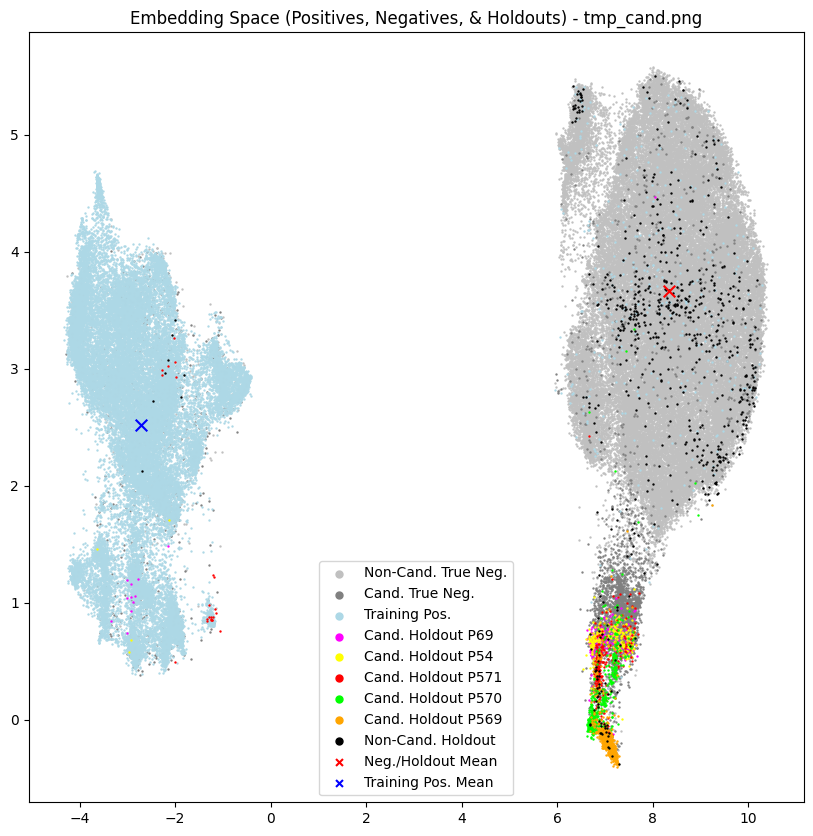

Dimension Reducing (umap)...
-=-=-=PLOT INFO=-=-=-
NUM. POS: 0
NUM. HOLDOUT: 2988
NUM. NEG: 97012
-=-=-=-
LABEL: P69 286/307 (0.93) candidates
-----
LABEL: P54 270/373 (0.72) candidates
-----
LABEL: P571 270/460 (0.59) candidates
-----
LABEL: P570 625/804 (0.78) candidates
-----
LABEL: P569 896/1044 (0.86) candidates
-----


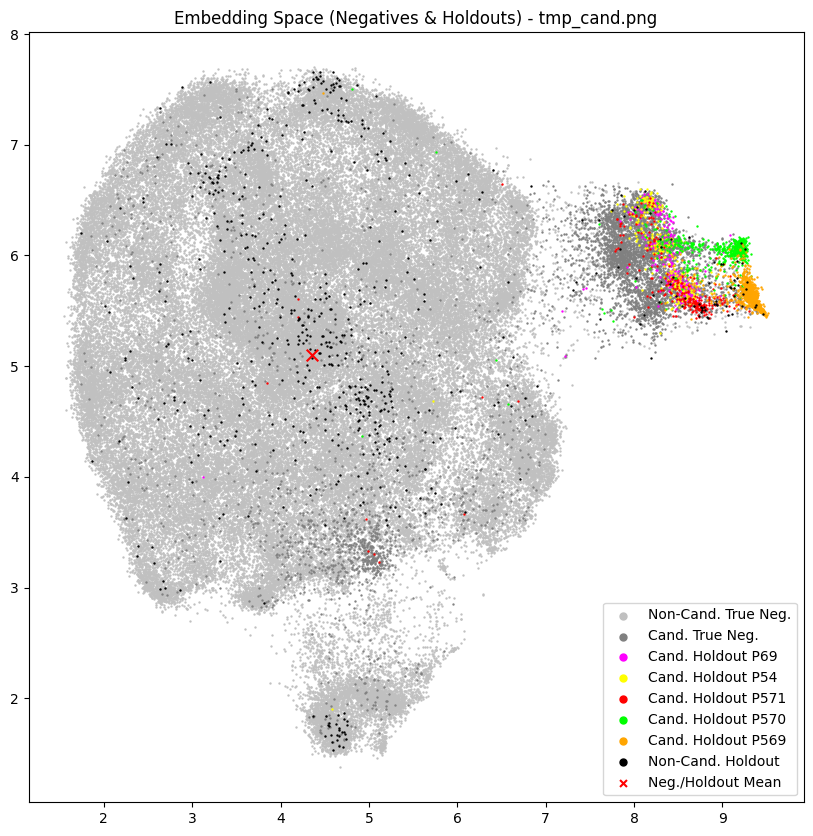

{'cand_ct': 71147,
 'holdouts': {'holdout_cand_ct': 2347,
              'holdout_cand_ratio': 0.785475234270415,
              'holdout_ct': 2988,
              'ratio_all_cand_holdout': 0.03298803884914332},
 'negatives': {'neg_cand_ct': 68800,
               'neg_cand_ratio': 0.05915557141444582,
               'neg_ct': 1163035,
               'ratio_all_cand_neg': 0.9670119611508566},
 'per_class_retain': {'P54': {'cand_count': 270.0,
                              'cand_ratio': 0.7238605898123325,
                              'count': 373.0},
                      'P569': {'cand_count': 896.0,
                               'cand_ratio': 0.8582375478927203,
                               'count': 1044.0},
                      'P570': {'cand_count': 625.0,
                               'cand_ratio': 0.777363184079602,
                               'count': 804.0},
                      'P571': {'cand_count': 270.0,
                               'cand_ratio': 0.5869565217391305,

In [6]:
from eval_candidates import candidates_evaluate
from pprint import pprint

stats, cand_mask = candidates_evaluate(embeddings, labels, labels_original, id2rel_original, 'tmp_cand.png')
pprint(stats)

In [ ]:
# torch.save(cand_mask, os.path.join(checkpoint_dir, 'latest-contr-cand-mask.pt'))
# json.dump(stats, open(os.path.join(checkpoint_dir, 'test_stats.json'), 'w'), indent=2)
# torch.load(os.path.join(checkpoint_dir, 'latest-contr-cand-mask.pt')).sum().item()